_Lambda School Data Science, Unit 2_
 
# Regression 2 Sprint Challenge: Predict drugstore sales 🏥

For your Sprint Challenge, you'll use real-world sales data from a German drugstore chain, from Jan 2, 2013 — July 31, 2015.

You are given three dataframes:

- `train`: historical sales data for 100 stores
- `test`: historical sales data for 100 different stores
- `store`: supplemental information about the stores


The train and test set do _not_ have different date ranges. But they _do_ have different store ids. Your task is _not_ to forecast future sales from past sales. **Your task is to predict sales at unknown stores, from sales at known stores.**

In [4]:
import pandas as pd
train = pd.read_csv('https://drive.google.com/uc?export=download&id=1E9rgiGf1f_WL2S4-V6gD7ZhB8r8Yb_lE')
test = pd.read_csv('https://drive.google.com/uc?export=download&id=1vkaVptn4TTYC9-YPZvbvmfDNHVR8aUml')
store = pd.read_csv('https://drive.google.com/uc?export=download&id=1rZD-V1mWydeytptQfr-NL7dBqre6lZMo')
assert train.shape == (78400, 7)
assert test.shape == (78400, 7)
assert store.shape == (200, 10)

In [41]:
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error,mean_squared_log_error
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.model_selection import cross_val_score,RandomizedSearchCV
from scipy.stats import randint, uniform
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
from eli5.sklearn import PermutationImportance

The dataframes have a variety of columns:

- **Store** - a unique Id for each store
- **DayOfWeek** - integer, 1-6
- **Date** - the date, from Jan 2, 2013 — July 31, 2015.
- **Sales** - the units of inventory sold on a given date (this is the target you are predicting)
- **Customers** - the number of customers on a given date
- **Promo** - indicates whether a store is running a promo on that day
- **SchoolHoliday** - indicates the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

This Sprint Challenge has three parts. To demonstrate mastery on each part, do all the required instructions. To earn a score of "3" for the part, also do the stretch goals.

## 1. Wrangle relational data, Log-transform the target
- Merge the `store` dataframe with the `train` and `test` dataframes. 
- Arrange the X matrix and y vector for the train and test sets.
- Log-transform the target for the train and test set.
- Plot the target's distribution for the train set, before and after the transformation.

#### Stretch goals
- Engineer 3+ more features.

In [6]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,4,5,2015-07-31,13995,1498,1,1
1,8,5,2015-07-31,8492,833,1,1
2,11,5,2015-07-31,10457,1236,1,1
3,12,5,2015-07-31,8959,962,1,1
4,34,5,2015-07-31,11144,1162,1,1


In [7]:
test.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,SchoolHoliday
0,10,5,2015-07-31,7185,681,1,1
1,15,5,2015-07-31,9191,766,1,1
2,31,5,2015-07-31,7248,645,1,1
3,47,5,2015-07-31,9379,1021,1,1
4,53,5,2015-07-31,7540,690,1,1


In [8]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
1,8,a,a,7520.0,10.0,2014.0,0,NaN,NaN,NaN
2,10,a,a,3160.0,9.0,2009.0,0,NaN,NaN,NaN
3,11,a,c,960.0,11.0,2011.0,1,1.0,2012.0,"Jan,Apr,Jul,Oct"
4,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"


In [9]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Promo            0
SchoolHoliday    0
dtype: int64

In [10]:
train.shape

(78400, 7)

**Feature Engineering**

In [11]:
def wrangle(X):
    X = X.copy()
    X = X.merge(store, how='left')
    
    # add month, day, year columns and drop Date column 
    X['Date'] = pd.to_datetime(X['Date'], infer_datetime_format=True)
    X['Year'] = X['Date'].dt.year
    X['Month'] = X['Date'].dt.month
    X['Day'] = X['Date'].dt.day
    X = X.drop(columns='Date')
    
    #If there was a promo and school holiday 
    X['promo_hol'] = X['Promo']+X['SchoolHoliday']
    X['promo_hol'] = X['promo_hol'].apply(lambda x: 1 if x == 2 else 0)
    
    
    #One Hot encode StoreType and Assortment
    one_hot = pd.get_dummies(X['Assortment'],prefix = 'Assortment')
    one_hot_1 = pd.get_dummies(X['StoreType'],prefix = 'StoreType')
    X = X.drop(columns='Assortment')
    X = X.drop(columns='StoreType')
    X = X.join(one_hot)
    X = X.join(one_hot_1)
    
    return X
    

In [12]:
train_wrangled = wrangle(train)
test_wrangled = wrangle(test)

In [13]:
train_wrangled.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Promo', 'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval', 'Year', 'Month', 'Day', 'promo_hol',
       'Assortment_a', 'Assortment_c', 'StoreType_a', 'StoreType_c',
       'StoreType_d'],
      dtype='object')

**Arrange the X matrix and y vector for the train and test sets**

In [14]:
target = 'Sales'
X_train = train_wrangled.drop(columns=target)
X_test = test_wrangled.drop(columns=target)
y_train = train_wrangled[target]
y_test = test_wrangled[target]

**target's distribution for the train set before transformation**

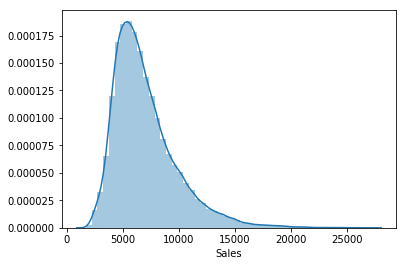

In [15]:
sns.distplot(y_train);

**Log-transform the target for the train and test set**

In [46]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

**target's distribution for the train set after transformation**

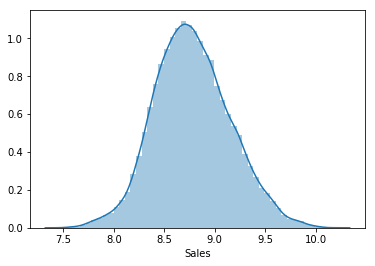

In [47]:
sns.distplot(y_train_log);

## 2. Fit and validate your model
- **Use Gradient Boosting** or any type of regression model.
- **Beat the baseline:** The estimated baseline Root Mean Squared Logarithmic Error is 0.90, if we guessed the mean sales for every prediction. Remember that RMSE with the log-transformed target is equivalent to RMSLE with the original target. Try to get your error below 0.20.
- **To validate your model, choose any one of these options:**
  - Split the train dataframe into train and validation sets. Put all dates for a given store into the same set. Use xgboost `early_stopping_rounds` with the validation set. 
  - Or, use scikit-learn `cross_val_score`. Put all dates for a given store into the same fold.
  - Or, use scikit-learn `RandomizedSearchCV` for hyperparameter optimization. Put all dates for a given store into the same fold.
- **Get the Validation Error** (multiple times if you try multiple iterations) **and Test Error** (one time, at the end).
  
#### Stretch goal
- Optimize 3+ hyperparameters by searching 10+ "candidates" (possible combinations of hyperparameters). 

In [17]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

**Baseline**

In [18]:
b = np.full_like(y_train, fill_value=y_train.mean())
print("Baseline Error : %.3f" %rmsle(y_test,b))

Baseline Error : 0.395


**Model Validation with Cross Val Score**

In [19]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

groups = train['Store']

In [20]:
scores = cross_val_score(pipeline, 
                         X_train, 
                         y_train_log, 
                         cv=3, 
                         scoring='neg_mean_squared_error', 
                         groups=groups)

[19:50:15] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:50:24] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [21]:
print(f'RMSLE for 3 folds:', np.sqrt(-scores))

RMSLE for 3 folds: [0.09534555 0.09129407 0.08811653]


**HyperParameter Optimization**

In [22]:
param_distributions = {
    'xgbregressor__n_estimators': randint(50, 500),
    'xgbregressor__max_depth': randint(3, 10)
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=10,
    return_train_score=True,
    n_jobs=-1)

search.fit(X_train, y_train_log, groups=groups);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed:  1.6min remaining:   49.0s
[Parallel(n_jobs=-1)]: Done  12 out of  15 | elapsed:  1.9min remaining:   29.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  2.9min finished


[19:53:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [23]:
print('Best hyperparameters', search.best_params_)
print('Cross_validation RMSLE', np.sqrt(-search.best_score_))

Best hyperparameters {'xgbregressor__max_depth': 9, 'xgbregressor__n_estimators': 409}
Cross_validation RMSLE 0.05834226605561387


**Test Error**

In [24]:
pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    XGBRegressor(max_depth = 9, n_estimators=409, random_state=42, n_jobs=-1)
)

In [25]:
pipeline.fit(X_train, y_train_log)
y_pred_log = pipeline.predict(X_test)

[19:54:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [26]:
print("Error : %.5f" %rmse(y_test_log, y_pred_log))

Error : 0.14282


## 3. Plot model interpretation visualizations
- Choose any one of these options:
  - Permutation Importances plot
  - Partial Dependency Plot, 1 feature isolation
  - Partial Dependency Plot, 2 feature interaction
  
#### Stretch goals
- Plot 2+ visualizations.
- Use permutation importances for feature selection. 

In [27]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

**Partial Dependency Plot, 1 feature isolation**

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a24d1fc18>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2160f3c8>})

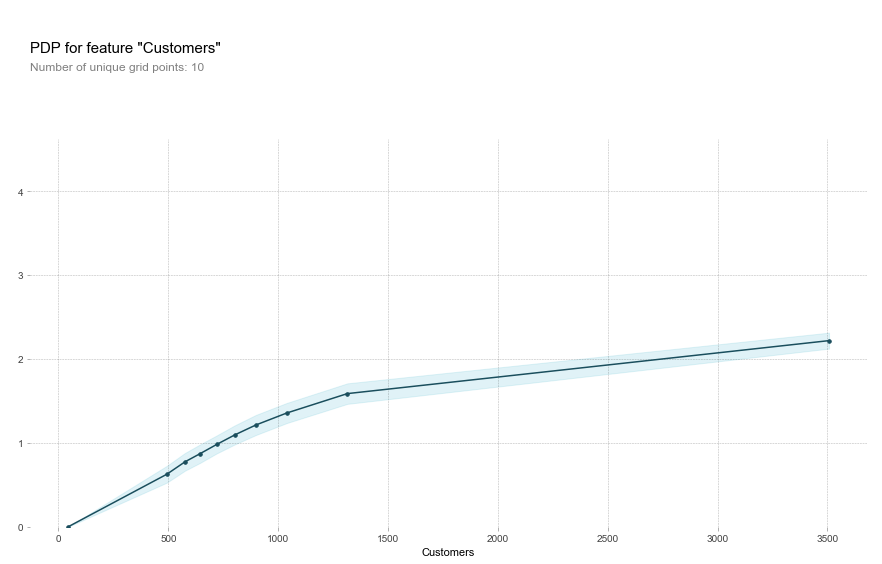

In [35]:
features ='Customers'

isolated = pdp_isolate(
    model=pipeline.named_steps['xgbregressor'], 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=features
)

pdp_plot(isolated, feature_name=features)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a21d8fba8>,
  'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a284f3d30>})

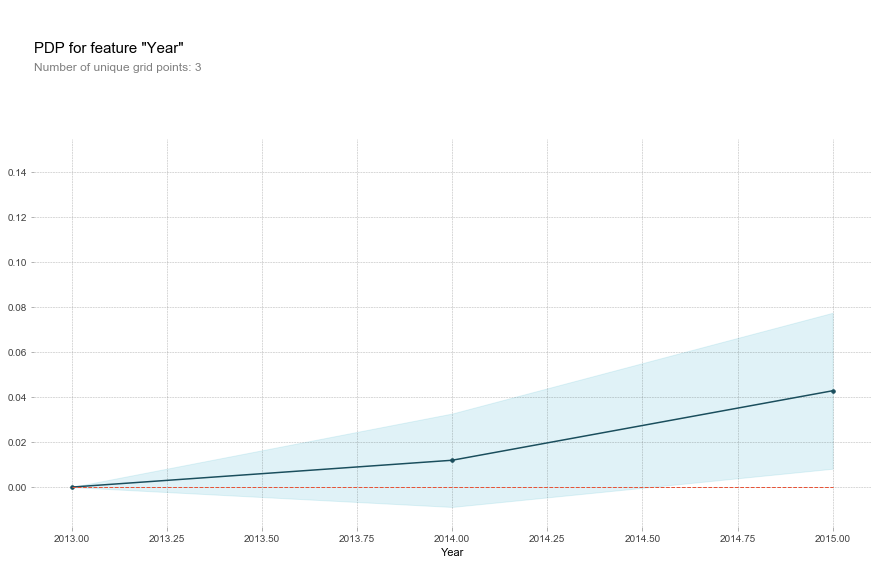

In [39]:
features ='Year'

isolated = pdp_isolate(
    model=pipeline.named_steps['xgbregressor'], 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    feature=features
)

pdp_plot(isolated, feature_name=features)

**Partial Dependency Plot, 2 feature interaction**

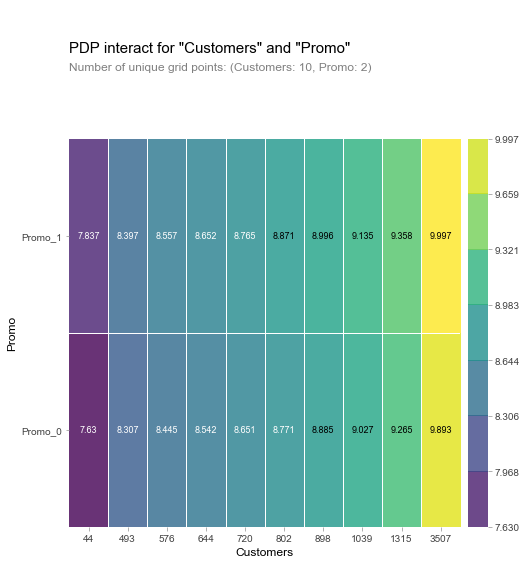

In [48]:
features = ['Customers', 'Promo']

interaction = pdp_interact(
    model=pipeline.named_steps['xgbregressor'], 
    dataset=X_test_encoded, 
    model_features=X_test_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

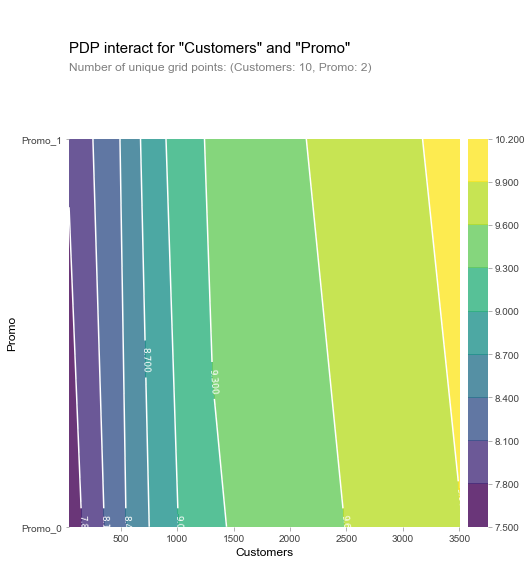

In [49]:
pdp_interact_plot(interaction, plot_type='contour', feature_names=features);